

<img src="Movie1.jpg">
<h1 style="line-height:15px;"><center> Movie Industy and Rating of a Movie </center></h1>
<h3 style="line-height:5px;"> Author:  Tianrui Guan, Xuejing Wang, Kaiyin Li </h3>
<h6 style="line-height:1px;"> Published: Dec 8, 2018 </h6>

<h2>Table of Contents</h2>

<ol style="font-size:115%;line-height:25px;">
    <li>
        <strong>Introduction</strong>
        <ul>
            <li>Background and Motivation</li>
            <li>About data</li>
            <li>Relevant information</li><br>
        </ul>
    </li>
    <li>
        <strong>Data Scraping</strong>       
    </li>
    <li>
        <strong>Data Wrangling</strong>
        <ul>
            <li>Data Cleaning and Tidying</li>
            <li>Missing data and Imputation</li>
        </ul>
    </li>
    <li>
        <strong>Data Visualization and Exploratory Data Analysis</strong>
        <ul>
            <li>Grouped by Companies</li>
            <li>Grouped by Countries</li>
            <li>Budget v.s. Gross Profit? Revenue?</li><br>
        </ul>
    </li>
    <li>
        <strong>Prediction</strong>
        <ul>
            <li>Prediction of Rating of a movie</li>
            <li>Cluster 3</li>
            <li> ... </li><br>
        </ul>
    </li>
    <li>
        <strong>Conclusions</strong>
        <ul>
            <li> Summary </li>
            <li> Other Problems </li><br>
        </ul>
    </li>
    <li>
        <strong>appendix</strong>
        <ul>
            <li>Relevent resources</li>
            <li>Sources files</li><br>
        </ul>
    </li>
</ol>


## 1. Introduction
### Background and Motivations

Movie business is risky. From the IMDb website, we found records for more than seven thousand movies since 1986. However, the ones that can be called "successful" or make decent profit are only a significantly small part of the entire movie industry. In this tutorial, we would like to explore their "secret" of success. Does large investment guarantee high profit? Does star-power bring popularity? Are there any underlying factors that cause their success? Are those popular movies really of good quality?

To answer these questions, we collected data from the Internet Movie Database ([IMDb](https://www.imdb.com/)). IMDb is an online database of information related to films, television programs, home videos and video games. According to wikipedia, IMDb has approximately 5.3 million titles (including episodes) as well as 83 million registered users before Octoer 2018. Because of the authority and completeness of IMDb, we decided to scrap data on the website, analyze the layout of the moive industry globally and try to predict the potential success about an incoming movie.

### About data
The data was scrapped from [IMDb](https://www.imdb.com/). In the raw data, there are 7260 data points, including all of the movies from 1986 to 2018. Each movie has 13 attributes as following:
<ul style="line-height:25px;">
    <li>Name: name of the movie</li>
    <li>Year: year of release</li>
    <li>Released: specific date of release</li>
    <li>Genre: categories</li>
    <li>Rating: content rating(some details)<br>
         <ul>
             <li>G: General Audiences</li>
             <li>PG: Parental Guidance Suggested</li>
             <li>PG-13: Special Guidance for Children Under 13</li>
             <li>R: Accompanying of parent Under 17</li>
             <li>Others: TV-PG, TV-14, TV-MA and NC-17</li>
        </ul>
    </li>
    <li>Runtime: the length of the movie(in minutes)</li>
    <li>Score: the score of the movie, from 0 to 10</li>
    <li>Votes: the number of comments made regarding the movie</li>
    <li>Companies: list of companies involved in the production</li>
    <li>Country: the country that produced the movie</li>
    <li>Language: the language used in the movie</li>
    <li>Budget: budget of a movie</li>
    <li>Gross: the profit of a movie, which is revenue minus the cost</li>
</ul>

Due to the fact that the data is huge, we scrapped it in the script and stored it in the csv file. But we also put our scrapping code in the notebook. 

### Relevant information

The idea was inspired by a [dataset](https://www.kaggle.com/danielgrijalvas/movies) from kaggle about Movie Industry. But their data was out of date (with movies only before 2016) and some of the information was not captured (for some features like company and genre, only one of them was scrapped). Therefore, we decided to write the scrapping code and create our own dataset. We deleted and added a few columns that are relevant to our discussion, made sure that we included all informations we want, and added data from 2017 to 2018.


## 2. Data Scraping



From [IMDb](https://www.imdb.com/), we scrapped 7260 movie information. First, there are some necessary import and some helper function:

In [75]:
!pip install missingno
# import necessary code for scrapping.
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import json

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [76]:
# home page of IMDb
root = 'http://www.imdb.com'
# format of the urls we are interested, passing in different years.
url = ('http://www.imdb.com/search/title?count=220&view=simple'
    '&boxoffice_gross_us=1,&title_type=feature&release_date={year}')
# http header sent with the quests
headers = {'Accept-Language': 'en-US'}


In [77]:
# some useful functions:

# this function pass in a year as int, 
# and return a list of urls movies released in that year.
def get_movies(year):
    # request pages on that year.
    movies_html = requests.get(url.format(year=year), headers=headers).content
    # use beautiful soup to parse the page requested
    soup = BeautifulSoup(movies_html, 'html.parser')
    # find all of the links in the webpage regarding a movie
    movies = soup.findAll('a', {'href': re.compile('adv_li_i$')})
    # return a list of urls of this year.
    return [root + m['href'] for m in movies]

# pass in a full url about a movie, 
# and reutrn the content requested before parsed
def go_to_movie(url):
    movie_html = requests.get(url, headers=headers).content
    return movie_html

# pass in a full url about a production company, 
# and return the name of the company in string.
# if the page is corrupted, or the connection has timeout,
# return empty string
def get_company(url):
    # Due to internet issue, we try multiple times when we failed. 
    # (it happened and I'll have to parse the whole year again. 
    # To reduce the chances of failure, try many times before gave up)
    for i in range(5):
        # This is one of 7000 cases where the link doesn't work, 
        # so just return empty string
        if '/company/co0677497/' in url:
            return ''
        try:
            # scrap the name of the company
            html = requests.get(url, headers=headers).content
            soup = BeautifulSoup(html, 'html.parser')
            company = soup.find("meta",  property="og:title")['content'].replace('With', '(').split('(')[1].strip()
            return company
        # catch connection error, and give up after five times.
        except ConnectionError:
            continue;
    return ''

# append a list of data into the file without index
def write_csv(data):
    df = pd.DataFrame(data)
    # we stored the data in the file called movies_new.csv
    df.to_csv('movies_new.csv', mode='a', index=False)


In [78]:
# This is the page where we do most of the work for a movie.
# we pass in a beautifulsoup object regarding a movie after
# parsed by a html parser, as well as the current year we are parsing,
# in case of we can not find year information in the webpage
def scrap_details(soup, search_year):
    # first we find a tag that includes a formatted json
    details = soup.find("script", type="application/ld+json")
    js = json.loads(details.text)
    
    # access name and genre fields
    name = js['name']
    if isinstance(js['genre'], str):
        genre = js['genre']
    else:
        genre = ','.join(js['genre'])

    # The content rating of a movie,
    try:
        rating = js['contentRating']
    except KeyError:
        # if it is not given, use 'Not specified'.
        rating = 'Not specified'
        
    # find duration of the movie
    try:
        runtime = int(soup.find('h4', string='Runtime:').parent.contents[3].text[:-3].strip())
    except AttributeError:
        # if we can't, use another field and parse the string mannually
        time = re.findall(r'\d+', js['duration'])
        if len(time) > 1:
            runtime = 60 * int(time[0]) + int(time[1])
        else: 
            runtime = 60 * int(time[0])
    # find the release year and date
    try:
        year = js['datePublished'][:4]
        released = js['datePublished']
    except KeyError:
        # if it is not in the json format, use a string passed in 
        # and use 'Not specified' on the date.
        # note that sometimes the release year may differ from the year 
        # show up in the search page, so I use the year in the 
        # web search only if we can not find publish date about the movie
        year = str(search_year)
        released = 'Not specified'

    # the rating of the movie and how many comments it has
    score = float(js['aggregateRating']['ratingValue'])
    votes = int(js['aggregateRating']['ratingCount'])
    

    
    try:
        # get list of suffixes about url of a company
        companies_url = [ c['url'] for c in js['creator'] if c['@type'] == 'Organization' ]
        if companies_url:
            # if the list is not empty, then connect them with ',',
            # use get_company and store the company name (make sure to exclude empty string)
            companies = ','.join([ u for u in [ get_company(root+c_url) for c_url in companies_url ] if u != ''])
        else:
            # if it is empty, it means the creator is not specified, or all of the creation
            # and production was done by individuals
            companies = 'Personal'
    except TypeError:
        # if the result was not well-formatted (specifically, when there is only one creator,
        # the field was no longer a list, so just access the element directly.)
        if js['creator']['@type'] == 'Organization':
            companies = get_company(root+js['creator']['url'])
        else:
            companies = 'Personal'

    # locate the information about country and language in the beautifulsoup object
    country = soup.find('a', {'href': re.compile('country_of_origin')}).text
    language = ','.join(l.text for l in soup.find_all('a', {'href': re.compile('primary_language')}) )

    # find the budget field and convert it to float
    try:
        budget = soup.find('h4', string='Budget:').parent.contents[2].strip()
        if not '$' in budget:
            # in case the field was not well formatted
            budget = 'Not specified'
        else:
            budget = float(budget.replace('$','').replace(',',''))
    except AttributeError:
        # if we can not find budget information
        budget = 'Not specified'

    # find gross profit in the website, using either Cumulative Worldwide Gross
    # or Gross USA, whichever is available
    try:
        gross = soup.find('h4', string='Cumulative Worldwide Gross:').parent.contents[2].strip()[:-1]
        gross = float(gross.replace('$','').replace(',',''))
    except (AttributeError, ValueError):
        try:
            gross = soup.find('h4', string='Gross USA:').parent.contents[2].strip()[:-1]
            gross = float(gross.replace('$','').replace(',',''))
        except (AttributeError, ValueError):
            gross = 'Not specified'
    # return all of the data about the movie
    data_line = {'name': name, 'rating': rating, 'genre': genre, 'runtime': runtime, 'year': year, 
                 'released': released, 'score': score, 'votes': votes, 'rating': rating, 'companies': companies, 
                 'country': country, 'language': language, 'budget': budget, 'gross': gross}

    return data_line



In [79]:
# This is the main function in the script, to make sure it will not run,
# we left it in the main function.

def main():
    # from 1986 to 2018
    for year in range(1986, 2019):
        data = []
        # get all of the urls of movies in this year
        movies = get_movies(year)

        for movie_url in movies:
            # for each movie, I print out the informations for debuggging purpose
            print(year, '&', movie_url)
            movie_data = {}
            # get html text and use html parser to parse it
            movie_html = go_to_movie(movie_url)
            soup = BeautifulSoup(movie_html, 'html.parser')
            
            # scrap data and put it in the yearly data.
            movie_data.update(scrap_details(soup, year))
            data.append(movie_data)
        # For every year, we append all of the information once to the movie and show a prompt
        # Note that since we don't have an id for a movie, so there is not way
        # to start where we left off when the program breaks due to a bug. 
        # we can only start from scratch at different years when that happened.
        write_csv(data)
        print(year, 'done.')


Note that, even if we parsed our own data, we should not expect that our data is nice and clean. So we need to look at the data and clean it up for analysis.

## 3. Data Wrangling
### Data Cleaning and Tidying
At this step, we need to look at our data and clean it up. Import necessary tools:

In [80]:
# pandas for dataframe
import pandas as pd
# linear algebra
import numpy as np

# for data analysis
from sklearn import preprocessing
from sklearn import datasets
from scipy import stats
import math

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install missingno
import missingno as msno
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import LabelEncoder
sns.set(style="darkgrid")
pd.options.mode.chained_assignment = None 
lb_make = LabelEncoder()

First remove some repetitive rows of features resulted from appending data each year, change string about date into datetime object and reorganize the columns. Then we check for potential duplicated movies. 

In [81]:
# read the csv file
data = pd.read_csv('./movies_new.csv')
# When appending to the file at each yaer iteration, we repetitively added
# the columns features to the data. So we need to remove those
data = data[data.name != 'name']
# replace missing data with np.nan
data.replace(['Unrated', 'Not Rated', 'Not specified'], np.nan, inplace=True)
# converting time to datetime object
data['released_date'] = pd.to_datetime(data.released)
# fixing a mistake in scrapping data
p = re.compile('[A-Z],[a-z],')
old = np.unique(data[data.genre.str.match(p)]['genre'].values)
new = [n.replace(',', '') for n in old]
data['genre'].replace(old, new,inplace=True)
data = data[data.year != '2019']
# change types to int and float
data[['gross', 'budget', 'score', 'votes']] = data[['gross', 'budget', 'score', 'votes']].astype(float)


In [82]:
# check for potential duplicated elements by checking if there is movie with the same movie name and year.
# we append the string and check for duplicates
data['check'] = data.name + data.year
data[data.check.duplicated()].shape
# Since the resulting dataframe is empty, now we know that there is not duplicate rows.

(0, 15)

Then we noticed that on each row, there are multiple columns. So we want to tidy the data by splitting the companies, and here we got our final data. Finally we showed how many percent data were missing for each feature. 

In [83]:
# split the rows by creating a list of companies with a unique ID and merging the original dataframe on it
ll = []
for (i, l) in data[['check', 'companies']].iterrows():
    try:
        for s in (l[1].split(',')):
            ll.append([l[0], s])
    except AttributeError:
        ll.append([l[0], l[1]])
lst = pd.DataFrame(ll, columns=['check', 'company']);

# reorganize columns, taking out genre for now.
# 'genre',
order = ['name', 'year', 'released_date', 'rating', 'runtime', 'score',
         'votes', 'company', 'country', 'language', 'budget', 'gross']
data2 = pd.merge(lst, data, how='left', left_on='check', right_on='check')[order]
data2.head()

,name,year,released_date,rating,runtime,score,votes,company,country,language,budget,gross
0,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Paramount Pictures,USA,English,15000000.0,35683060.0
1,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Don Simpson/Jerry Bruckheimer Films,USA,English,15000000.0,35683060.0
2,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Twentieth Century Fox,USA,English,18500000.0,13106024.0
3,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Brandywine Productions,USA,English,18500000.0,13106024.0
4,Aliens,1986,1986-07-18,R,137,8.4,582947.0,SLM Production Group,USA,English,18500000.0,13106024.0


name             100.000000
year             100.000000
released_date     99.992915
rating            93.563129
runtime          100.000000
score            100.000000
votes            100.000000
company           99.971659
country          100.000000
language          99.982287
budget            67.206320
gross             99.649284
dtype: float64


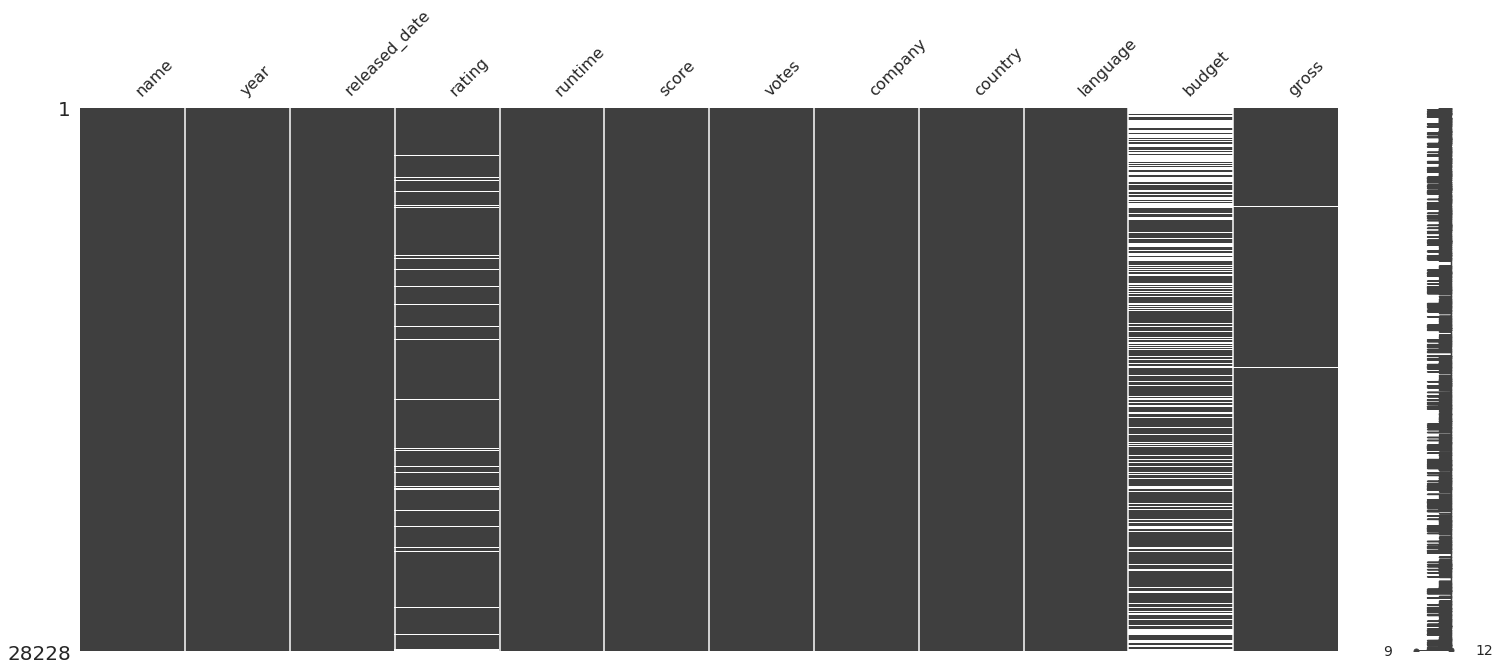

In [84]:
print(data2.notnull().sum()*100/data2.shape[0])
msno.matrix(data2)

### Missing data and Imputation

As it turn out, the data we collected is pretty good. Most of the features do not contain missing data. Around 6 percent of the movies are either not rated or missing, and features like data, companies, language and gross profit have only less than 1 percent of the missing value. However, budget has around 33 percent of missing data, which definitely need to be handled.

Since there are only 385 movies with missing value on released_date, rating, companies, language and gross, we decided to drop them for convience. Now we have 6875 movies and try to figure out a way to impute the budget. The following is the data after we drop those rows.

In [85]:
dataset = data2.dropna(subset=['released_date', 'rating', 'company', 'language', 'gross'])
print(dataset.notnull().sum()*100/dataset.shape[0])

name             100.00000
year             100.00000
released_date    100.00000
rating           100.00000
runtime          100.00000
score            100.00000
votes            100.00000
company          100.00000
country          100.00000
language         100.00000
budget            71.05103
gross            100.00000
dtype: float64


Now we need to decide how to impute our budget, so we need to think of a good way of imputing the data. We decided first to see which features are correlated to budget. Then consider if the data is missing at random or not using hypothesis testing.

In [86]:
mean_missing = dataset[dataset.budget.isnull()].gross.mean()
mean_not_missing = dataset[dataset.budget.notnull()].gross.mean()
print("mean gross income of movies with budget values: ", mean_not_missing)
print("mean gross income of movies without budget values: ", mean_missing)

mean gross income of movies with budget values:  36420154.5164
mean gross income of movies without budget values:  3686779.91278


We can see that movies without a budget value have significantly lower gross income than those who have a budget value. Thus the missing "budget" value has some relation with known data "gross" income. It is missing at random (MAR). We will impute the missing budget with a linear regression prediction.

In [87]:
X = dataset[dataset.budget.notnull()].gross
y = dataset[dataset.budget.notnull()].budget
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
print("b1: ", slope)
print("b0: ", intercept)
print("r: ", r_value)
print("p_value:", p_value)

b1:  0.168790519343
b0:  33718447.2721
r:  0.433719548338
p_value: 0.0


From the p_value of the coefficient b1, we can see that budget and gross income have a strong relationship, but gross income can only explain part of the variance in the budget. We consider this model good enough for imputation.

In [88]:
budget = []

for index, row in dataset.iterrows():
    if math.isnan(row['budget']):
        bgt = intercept + slope * row['gross']
    else:
        bgt = row['budget']
        
    budget.append(bgt)

dataset.loc[:, 'budget'] = budget

Now we have a set that is complete.

In [89]:
print(dataset.notnull().sum()*100/dataset.shape[0])

name             100.0
year             100.0
released_date    100.0
rating           100.0
runtime          100.0
score            100.0
votes            100.0
company          100.0
country          100.0
language         100.0
budget           100.0
gross            100.0
dtype: float64


## 4. Data Visualization and Exploratory Data Analysis

Rating(score) and box-office record(gross) are two important assessments for a movie, so we are going to explore the factors affecting them.

<h2>A. Factors that potentially affect rating of a movie</h2>
<h3>i. Companies</h3>

Since there are too many small companys without many data points, we decided to pick out only some of the groups and analyze those. Same for the other groups. We chose six producers that produced the most moives in the database.

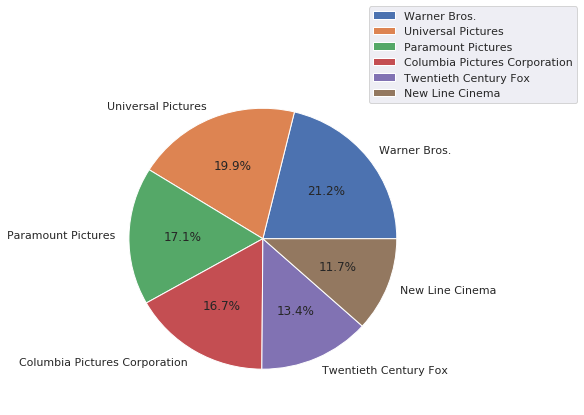

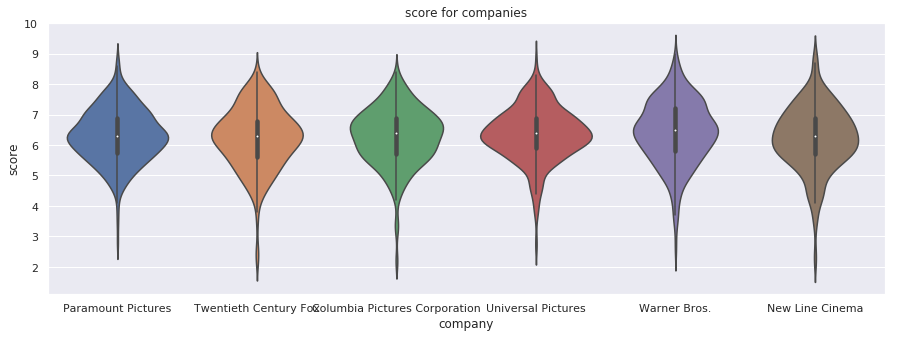

In [116]:
company_data = dataset[['company', 'score']].groupby(['company']).count()
company_data = company_data.sort_values(by='score', ascending=False)
set1 = dataset[dataset.company.isin(company_data.index[:6])]

pie1 = set1['company'].value_counts().reset_index()
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
plt.pie(x = pie1['company'], labels= pie1['index'],autopct= '%1.1f%%')
ax.legend(bbox_to_anchor=(0.8, 0.9))
plt.show()


plot1 = sns.violinplot(x = 'company', y = 'score', data = set1).set_title("score for companies")
plot1.figure.set_size_inches(15, 5);



As we can see, the market shares and the average scores are similar, the distribution all ranging from around 2 to 9.5 and we did not see a trend. And from the result of the least square model and anova, we can tell that they are not linearly corrrelated and there is not significant difference between those groups. Surprisingly, companies that produced more movies doesn't seem to make better movies than others, at least from the view of the audiences.

In [94]:
set1['company_code'] = lb_make.fit_transform(set1['company'])
model1 = ols(formula='score ~ C(company_code)', data=set1).fit() 
anova1 = anova_lm(model1)
print(model1.summary())
print(anova1)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.981
Date:                Fri, 14 Dec 2018   Prob (F-statistic):             0.0784
Time:                        00:24:32   Log-Likelihood:                -2892.4
No. Observations:                2098   AIC:                             5797.
Df Residuals:                    2092   BIC:                             5831.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.2786 

<h3>ii. Countries</h3>
Similarly, we picked 10 countries with more data points and compared them between country groups. We noticed that USA produced around 67 percent of movies compared to other 9 countries.

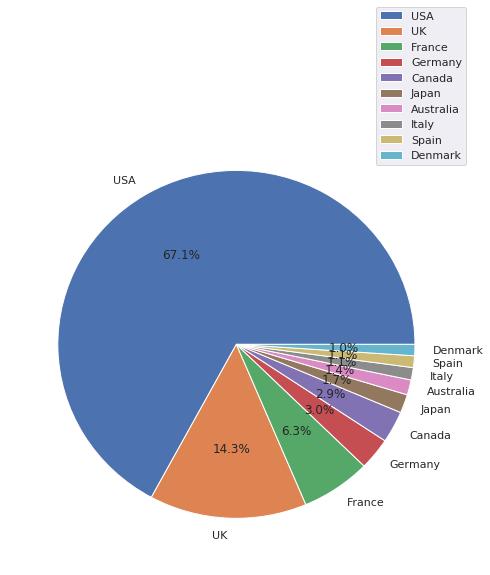

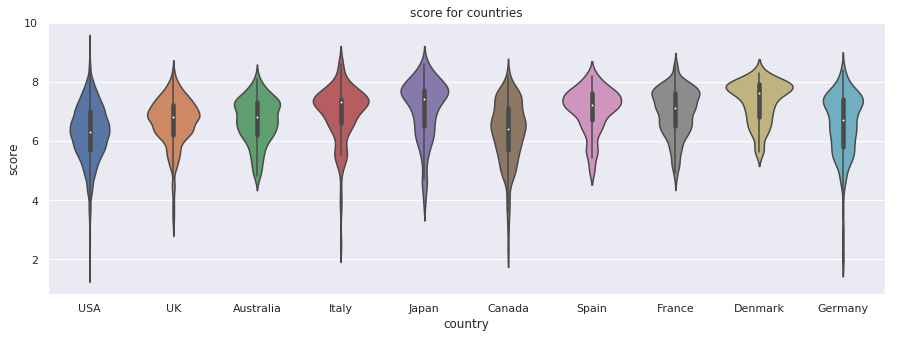

In [95]:
country_data = dataset[['country', 'score']].groupby(['country']).count()
country_data = country_data.sort_values(by='score', ascending=False)[:10]
set2 = dataset[dataset.country.isin(country_data.index)]

pie2 = set2['country'].value_counts().reset_index()
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.pie(x = pie2['country'], labels= pie2['index'],autopct= '%1.1f%%')
ax.legend(bbox_to_anchor=(0.8, 0.9))
plt.show()


plot2 = sns.violinplot(x = 'country', y = 'score', data = set2).set_title("score for countries")
plot2.figure.set_size_inches(15, 5);

In [96]:
set2['country_code'] = lb_make.fit_transform(set2['country'])
model2 = ols(formula='score ~ C(country_code)', data=set2).fit() 
anova2 = anova_lm(model2)
print(model2.summary())
print(anova2)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     199.6
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:24:33   Log-Likelihood:                -33147.
No. Observations:               24455   AIC:                         6.631e+04
Df Residuals:                   24445   BIC:                         6.640e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6666 

From the result, we can see that even thought there is no significant correlations between those groups, but those groups are signiciantly different.

<h2>B. Budget affects Gross Profit? Revenue?</h2>

It is natural to think that maybe budget and gross profits are linearly related because usually high payout comes with high rewards. So let's find out.

slope: 1.14036470396
intercept: -16693437.1139
r-value: 0.438728561438
p_value: 0.0
std_err: 0.0144038608495
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     6268.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:24:33   Log-Likelihood:            -5.1730e+05
No. Observations:               26298   AIC:                         1.035e+06
Df Residuals:                   26296   BIC:                         1.035e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

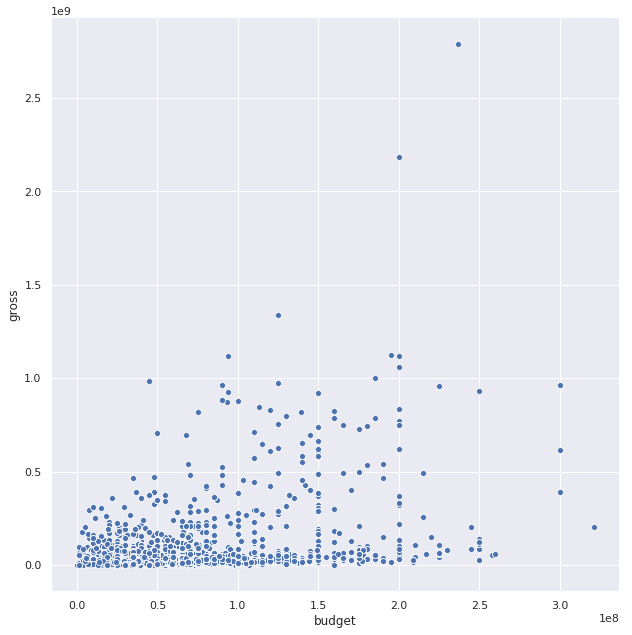

In [97]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.budget, dataset.gross)
print("slope:", slope)
print("intercept:", intercept)
print("r-value:", r_value)
print("p_value:", p_value)
print("std_err:", std_err)

model3 = ols(formula='gross ~ budget', data=dataset).fit()  
print(model3.summary())

plot3 = sns.relplot(x = "budget", y = "gross", data = dataset)
plot3.fig.set_size_inches(10, 10)


Note that the p-value is low and r-square is low, meaning they are correlated but this is a bad model. From the graph we can see the points are aggregated on y = 0. Maybe we can improve the linearity by introducing a new variable -- revenue.

slope: 2.14036470396
intercept: -16693437.1139
r-value: 0.675599979348
p_value: 0.0
std_err: 0.0144038608495
                            OLS Regression Results                            
Dep. Variable:                    rev   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                 2.208e+04
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:24:34   Log-Likelihood:            -5.1730e+05
No. Observations:               26298   AIC:                         1.035e+06
Df Residuals:                   26296   BIC:                         1.035e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

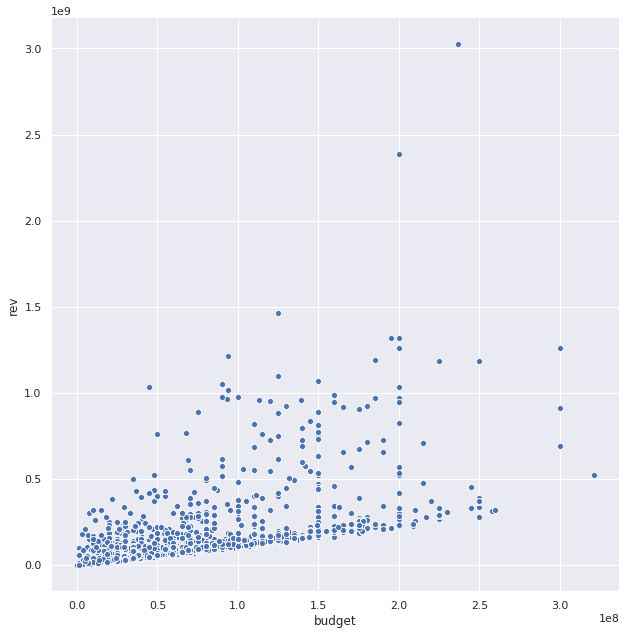

In [98]:
dataset['rev'] = dataset.budget + dataset.gross

slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.budget, dataset.rev)
print("slope:", slope)
print("intercept:", intercept)
print("r-value:", r_value)
print("p_value:", p_value)
print("std_err:", std_err)

model4 = ols(formula='rev ~ budget', data=dataset).fit()  
print(model4.summary())

plot4 = sns.relplot(x = "budget", y = "rev", data = dataset)
plot4.fig.set_size_inches(10, 10)


Now r-value was boosted to 0.6, and now we have a better model. But there are still some many outliers, which makes sense because only few of the movies were big hit for most of us. The successful movies do not come out everyday.<br><br>

We can further explore the relationship between these two assessments.
<h2>C. high score guarantee high profit?</h2>

**Method**: Draw a scatter plot of gross vs. score.

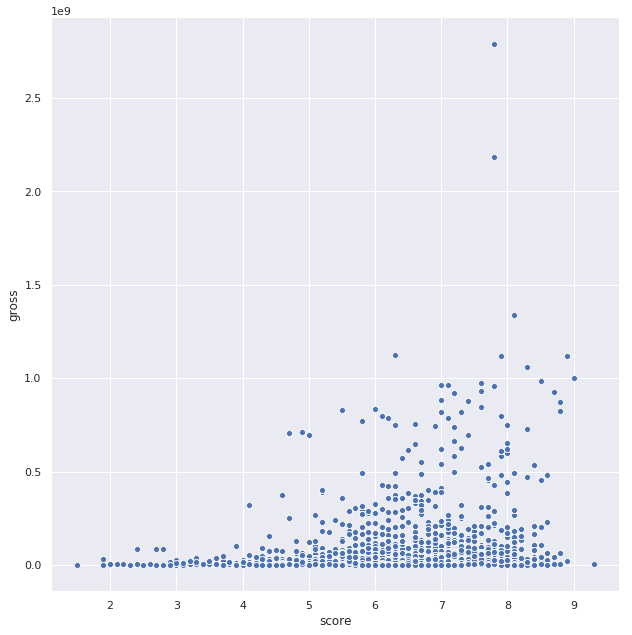

In [99]:
scatter_gross_score = sns.relplot(x = "score", y = "gross", data = dataset)
scatter_gross_score.fig.set_size_inches(10, 10)

From the scatter plot, we can see that there isn't a clear relationship between gross profit and score. But generally, movies with low score mostly make very low profit. A high score doesn't guarantee a high profit. Most of movies with high score make OK profit, with a few of them make significantly high profit. We'll draw a violin plot to better show the distribution of gross profit with different scores. Before that, we need to round the scores to its nearest integer.

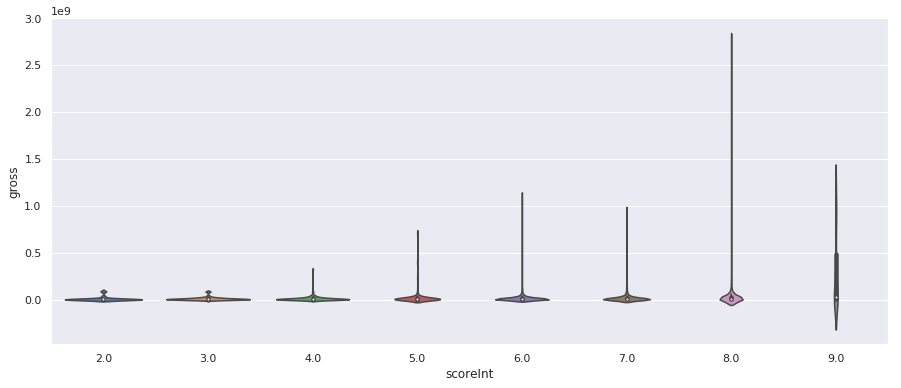

In [100]:
dataset["scoreInt"] = round(dataset["score"])
violin_gross_score = sns.violinplot(x = "scoreInt", y = "gross", data = dataset)
violin_gross_score.figure.set_size_inches(15, 6)

We found an interesting fact about movies of scores five and above. Most of the movies don't make much profit although they have high scores. However, there are always some of them that behave significantly better than the others.<br><br>


## 5. Prediction
From the analysis above, we can see that company and budget are main effect for the profits, so we are going to make multiple regression on them.

Since company is a categorical variable, we introduce a dummy variable called promising_company. The company in this  promising_company list produced the good selling movies in score 5 or higher levels.

Below, we make some rules to classify these companies.
We roughly set the boundary gross profit for a successful movie is $400,000,000.

We'll first plot the gross profit with respect to their companies.

In [117]:
data_score_5 = dataset[dataset["scoreInt"] == 5]
data_score_6 = dataset[dataset["scoreInt"] == 6]
data_score_56 = pd.concat([data_score_5, data_score_6])
data_score_56['company_code'] = lb_make.fit_transform(data_score_56['company'])

Companies that produce successful movies of score 5 and 6:
Universal Pictures
Temple Hill Entertainment
Summit Entertainment
Eon Productions
Twentieth Century Fox
DreamWorks Animation
Paramount Pictures
Columbia Pictures Corporation
DreamWorks
Warner Bros.
Walt Disney Pictures
Atlas Entertainment
Sony Pictures Animation
New Line Cinema


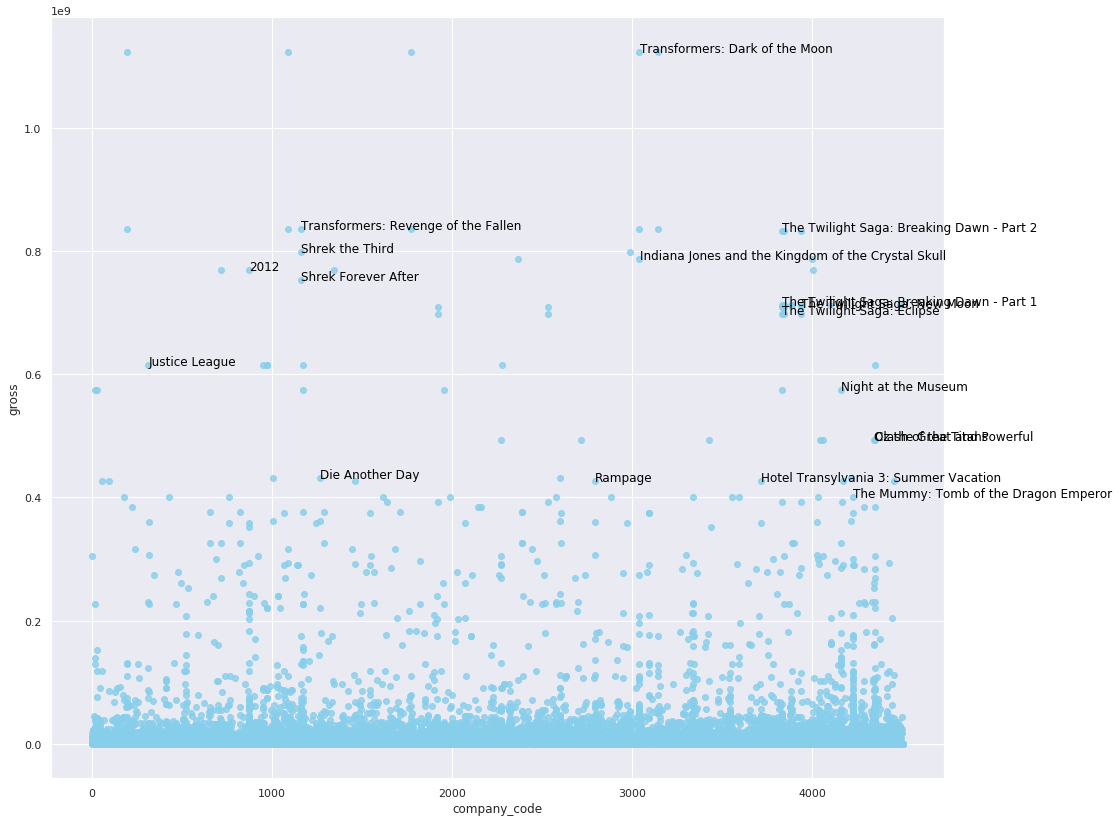

In [102]:
scatter_gross_company_56 = sns.regplot(x = "company_code", y = "gross", fit_reg=False, color="skyblue", data = data_score_56)
scatter_gross_company_56.figure.set_size_inches(16, 14)
company_56 = []
texted = []
print("Companies that produce successful movies of score 5 and 6:")
for index, row in data_score_56.iterrows():
    if row.gross >= 400000000 and row["name"] not in texted:
        texted.append(row["name"])
        if row["company"] not in company_56:
            print(row["company"])
            company_56.append(row["company"])
        scatter_gross_company_56.text(row.company_code+0.5, row.gross, row["name"], horizontalalignment='left', size='medium', color='black')
        


Companies that produce successful movies of score 7:
Twentieth Century Fox
Touchstone Pictures
Universal Pictures
Warner Bros.
Columbia Pictures Corporation
Lucasfilm
DreamWorks
Walt Disney Pictures
Twentieth Century Fox Animation
Paramount Pictures
DreamWorks Animation
Columbia Pictures


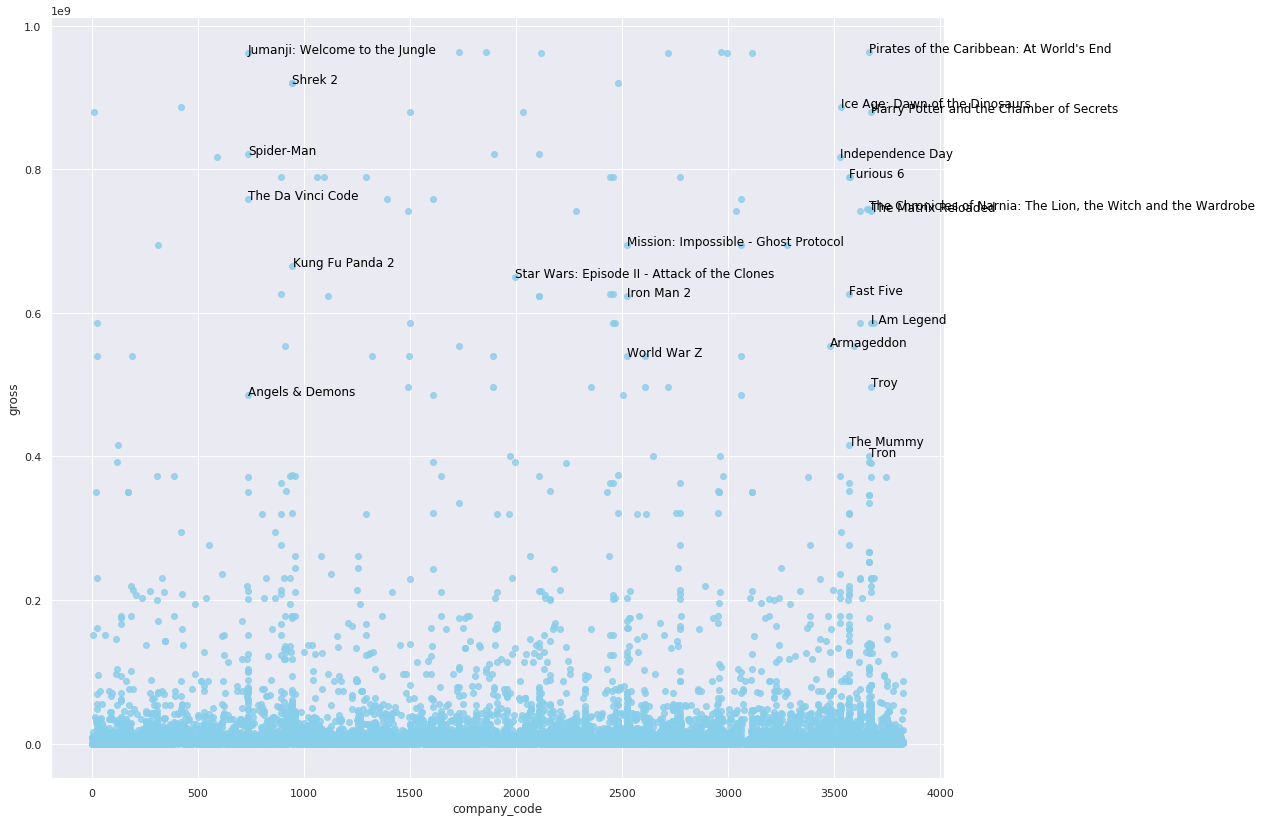

In [103]:
data_score_7 = dataset[dataset["scoreInt"] == 7]
data_score_7['company_code'] = lb_make.fit_transform(data_score_7['company'])
scatter_gross_company_7 = sns.regplot(x = "company_code", y = "gross", fit_reg=False, color="skyblue", data = data_score_7)
scatter_gross_company_7.figure.set_size_inches(16, 14)
texted = []
company_7 = []
print("Companies that produce successful movies of score 7:")
for index, row in data_score_7.iterrows():
    if row.gross >= 400000000 and row["name"] not in texted:
        if row["company"] not in company_7:
            company_7.append(row["company"])
            print(row["company"])
        texted.append(row["name"])
        scatter_gross_company_7.text(row.company_code+0.5, row.gross, row["name"], horizontalalignment='left', size='medium', color='black')

Companies that produce successful movies of score 8:
Paramount Pictures
Walt Disney Pictures
Twentieth Century Fox
Pixar Animation Studios
DreamWorks
Warner Bros.
Lucasfilm
Columbia Pictures Corporation
Universal Pictures
FortyFour Studios
DreamWorks Animation
Fox 2000 Pictures
Metro-Goldwyn-Mayer
New Line Cinema


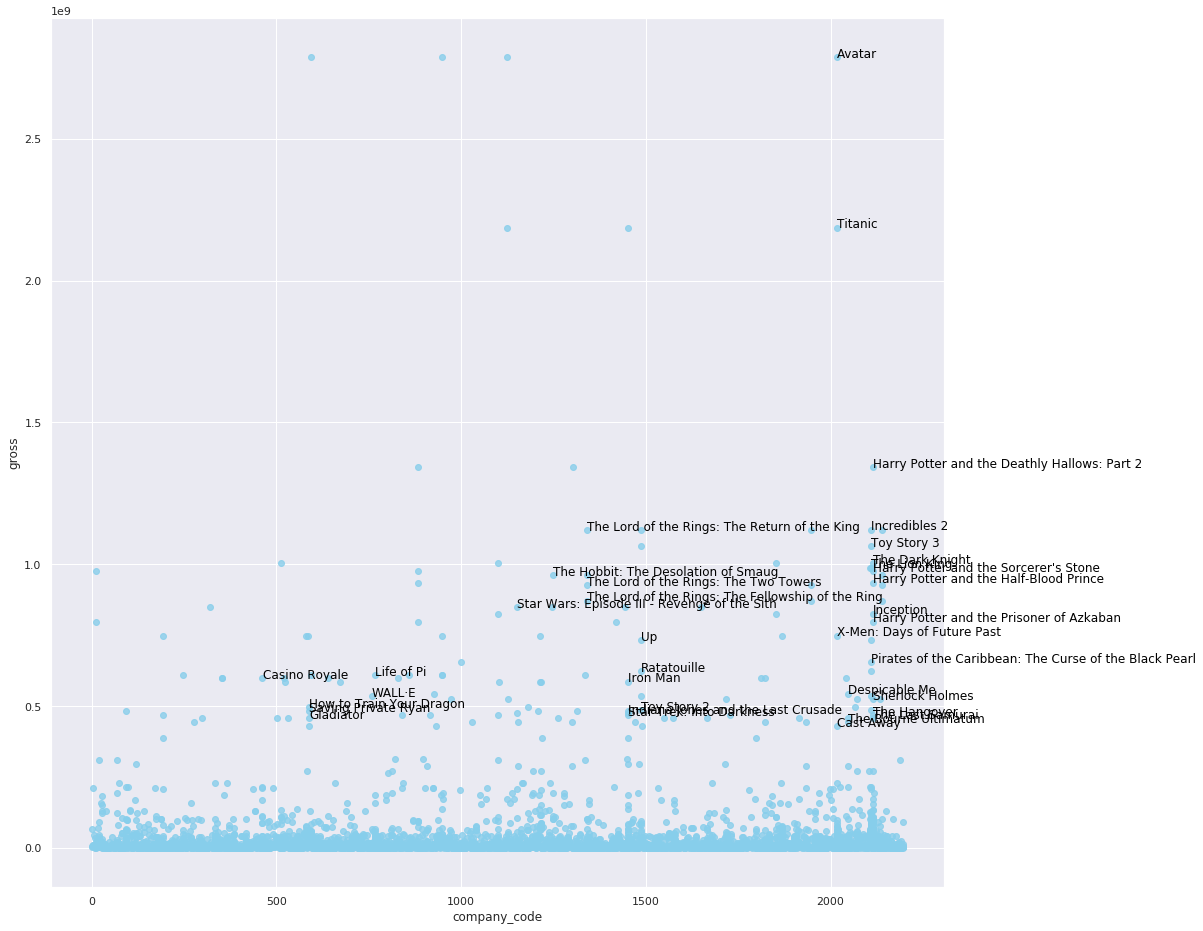

In [104]:
data_score_8 = dataset[dataset["scoreInt"] == 8]
data_score_9 = dataset[dataset["scoreInt"] == 9]
data_score_89 = pd.concat([data_score_8, data_score_9])
data_score_89['company_code'] = lb_make.fit_transform(data_score_89['company'])
scatter_gross_company_89 = sns.regplot(x = "company_code", y = "gross", fit_reg=False, color="skyblue", data = data_score_89)
scatter_gross_company_89.figure.set_size_inches(16, 16)
texted = []
company_89 = []
print("Companies that produce successful movies of score 8:")
for index, row in data_score_89.iterrows():
    if row.gross >= 400000000 and row["name"] not in texted:
        if row["company"] not in company_89:
            company_89.append(row["company"])
            print(row["company"])
        texted.append(row["name"])
        scatter_gross_company_89.text(row.company_code+0.5, row.gross, row["name"], horizontalalignment='left', size='medium', color='black')

We can see that those successful movies are from certain group of companies. Thus we label those companies as 1, and other companies as 0.

In [105]:
promising_company = set(company_56 + company_7 + company_89)
company_type = []
for index, row in dataset.iterrows():
    if row["company"] in promising_company:
        company_type.append(1)
    else:
        company_type.append(0)
        
dataset["company_type"] = company_type

In [110]:
model5 = ols(formula='rev ~ budget + company_type', data=dataset).fit()  
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    rev   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:37:04   Log-Likelihood:            -5.1729e+05
No. Observations:               26298   AIC:                         1.035e+06
Df Residuals:                   26295   BIC:                         1.035e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -1.72e+07   7.65e+05    -22.487   

## <i>revenue<i> = -1.72e+07 + 2.1287 * budget + 7.997e+06 * promising_company <br>
## <i>profit<i> = -budget - 1.72e+07 + 2.1287 * budget + 7.997e+06 * promising_company 

## 6. Conclusions

Movie investment is highly risky, and prediction of profits is complicated. The box-office success is affected by many factors, including topic, casting, budget, promotion and so on. Our model only include some of them, so it is not accurate enough. 
However, the regression gives some insights. 
First, it is intuitive that more budget can bring more profits. Second, we can see that if a company is good at making high- profits and high-rating movies in the past, it can add extra 8 million dollars.
<ul>
    <li><i>promising_company_profit<i> = -budget - 1.72e+07 + 2.1287 * budget + 7.997e+06</li>
    <li><i>nonpromising_company_profit<i> = -budget - 1.72e+07 + 2.1287 * budget</li>
</ul>

Also, there are some interesting findings:
1. For the six high-production companies(Paramount Pictures, Twentieth Century Fox, New Line Cinema, Universal Picture, Warner Bros, Columbia Pictures), the market shares and the average scores are roughly equal. Surprisingly, companies that produced more movies seem not to make better movies than others, at least from the view of the audiences.
2. Generally, movies with low score make very low profit. A high score doesn't guarantee a high profit. Most of movies with high score make OK profit, with a few of them make significantly high profit.
    